# I. Mirror number classification
### 1) MLP (multilayer perceptron) network

*Based on: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/*

Here we implement our first ML model for the basic task of classifying the number of mirrors in the system, based on the interference pattern. We start with a simple deep neural network - an MLP - which consists of several fully connected layers. 

In [1]:
# necessary imports

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from numpy import loadtxt
import numpy as np
import matplotlib.pyplot as plt

The input data is in the form of a CSV file, where each row has numbers separated by commas. The first value signifies the number of mirrors present in the system; subsequent numbers are the values of total transmittance for equally spaced wavenumbers k. The number of k values is constant through all the rows and depends on the generated data - the more k values, the more dense the probing of the k-space.

Let us load the dataset and visualize some interference pattern.

In [2]:
dataset = loadtxt('data50.csv', delimiter=',', skiprows=1)

# number of k samples
k_samples = 50

# number of classes (of mirror number)
num_classes = 8

# list of class labels
classes = [f'{class_id}' for class_id in range(3, 11)]

# mirror numbers (the correct classes) in the first column
y = dataset[:,0]

# convenient to have the classes starting from 0, so just subtract 3 from every y
y -= 3

# transmittance values
X = dataset[:,1:]

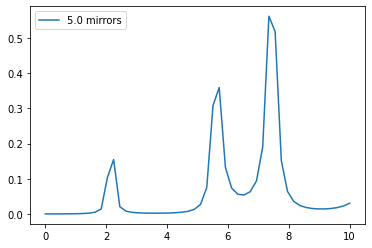

In [3]:
# k-space for plotting
kmin = 0
kmax = 10
ks = np.linspace(kmin, kmax, k_samples)

which_row = 10000

plt.figure()
plt.plot(ks, X[which_row], label=f'{y[which_row]+3} mirrors')
plt.legend(loc='best')
plt.show()

We will now split the dataset randomly into the training and test parts, borrowing a function from the scikit-learn package.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y, 
                                                    test_size = 0.25,
                                                    random_state = 42)

# the 'stratify = y' argument ensures that the training and testing sets contain the same proportion of each class
# we especially need to watch out for this for the lowest number of mirrors 
# which forms a tiny proportion of the whole dataset:

print('Proportion of 3-mirror elements in the testing set:', list(y_test).count(0) / len(y_test))
print('Proportion of 3-mirror elements in the testing set:', list(y_train).count(0) / len(y_train))

Proportion of 3-mirror elements in the testing set: 0.0018492804028186927
Proportion of 3-mirror elements in the testing set: 0.00184928440263788


Checks out. Let us build the network now (with the sizes of hidden layers chosen arbitrarily).

In [5]:
# Define the model
model = Sequential()
model.add(Dense(24, input_dim=k_samples, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='sigmoid'))

# The last layer consists of 8 nodes as we generated the data for 3 to 10 mirrors.

We shall define metrics to gauge the performance of our model using a useful function from the sklearn module. To have it evaluated after each epoch of the training, we will wrap it in a Keras callback. This callback will evaluate the classification report and log it to a log dictionary.

In [6]:
from sklearn.metrics import classification_report

classification_report_log_dict = {f'{class_id}' : {'precision': [], 'recall': [], 'f1-score': []} 
                                  for class_id in range(3, 11)} | {'accuracy': [], 
                                        'macro avg': {'precision': [], 'recall': [], 'f1-score': []},
                                        'weighted avg': {'precision': [], 'recall': [], 'f1-score': []}}

class PerformanceEvaluationCallback(keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        self.x_test = x_test
        self.y_test = y_test
        
    def on_epoch_end(self, epoch, logs=None):
        print('Evaluating the model...', end = ' ')
        y_pred = self.model.predict(self.x_test, verbose=0, batch_size = len(self.x_test))
        y_pred = np.argmax(y_pred, axis = 1)
        report = classification_report(self.y_test, y_pred, 
                              target_names = ['3','4','5','6','7','8','9','10'], output_dict = True)
        for class_id in classes + ['macro avg', 'weighted avg']:
            classification_report_log_dict[class_id]['precision'].append(report[class_id]['precision'])
            classification_report_log_dict[class_id]['recall'].append(report[class_id]['recall'])
            classification_report_log_dict[class_id]['f1-score'].append(report[class_id]['f1-score'])
        
        classification_report_log_dict['accuracy'].append(report['accuracy'])
        print(f"Accuracy: {report['accuracy']}")

        
        
performance_callback = PerformanceEvaluationCallback(X_test, y_test)

Now we compile.

In [7]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

Set necessary prerequisites and train, using the testing data for validation.

In [8]:
epochs = 100
batch_size = 10

callbacks = [
    performance_callback,
    
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/100
46235/46235 [==============================] - 55s 1ms/step - loss: 1.0492 - val_loss: 0.8548
Evaluating the model... Accuracy: 0.6252773920604228
Epoch 2/100
46235/46235 [==============================] - 51s 1ms/step - loss: 0.7565 - val_loss: 0.6824
Evaluating the model... Accuracy: 0.6979119353206068
Epoch 3/100
46235/46235 [==============================] - 52s 1ms/step - loss: 0.6092 - val_loss: 0.6088
Evaluating the model... Accuracy: 0.7276950828607395
Epoch 4/100
46235/46235 [==============================] - 49s 1ms/step - loss: 0.5156 - val_loss: 0.5207
Evaluating the model... Accuracy: 0.7555445968568721
Epoch 5/100
46235/46235 [==============================] - 48s 1ms/step - loss: 0.4503 - val_loss: 0.4191
Evaluating the model... Accuracy: 0.8007968127490039
Epoch 6/100
46235/46235 [==============================] - 47s 1ms/step - loss: 0.3969 - val_loss: 0.3808
Evaluating the model... Accuracy: 0.8043915543039568
Epoch 7/100
46235/46235 [=====================

46235/46235 [==============================] - 45s 969us/step - loss: 0.0783 - val_loss: 0.0912
Evaluating the model... Accuracy: 0.9069065756517902
Epoch 53/100
46235/46235 [==============================] - 46s 1ms/step - loss: 0.0768 - val_loss: 0.0894
Evaluating the model... Accuracy: 0.8946623927741801
Epoch 54/100
46235/46235 [==============================] - 46s 993us/step - loss: 0.0761 - val_loss: 0.0674
Evaluating the model... Accuracy: 0.9232710850409437
Epoch 55/100
46235/46235 [==============================] - 47s 1ms/step - loss: 0.0749 - val_loss: 0.0574
Evaluating the model... Accuracy: 0.9182682948985815
Epoch 56/100
46235/46235 [==============================] - 45s 971us/step - loss: 0.0741 - val_loss: 0.1026
Evaluating the model... Accuracy: 0.9037271110995756
Epoch 57/100
46235/46235 [==============================] - 47s 1ms/step - loss: 0.0725 - val_loss: 0.0720
Evaluating the model... Accuracy: 0.9130319114421792
Epoch 58/100
46235/46235 [=====================

The best model is saved and can be recovered with the following line:

In [9]:
#model = keras.models.load_model("best_model.h5")

Let us now plot the history of training.

In [10]:
import matplotlib.cm as cm
cmap = cm.get_cmap('jet')
colors = [cmap(i/7.) for i in range(8)]

First, the overall accuracy and averages of the class-dependent metrics: precision, recall and the F1 score.

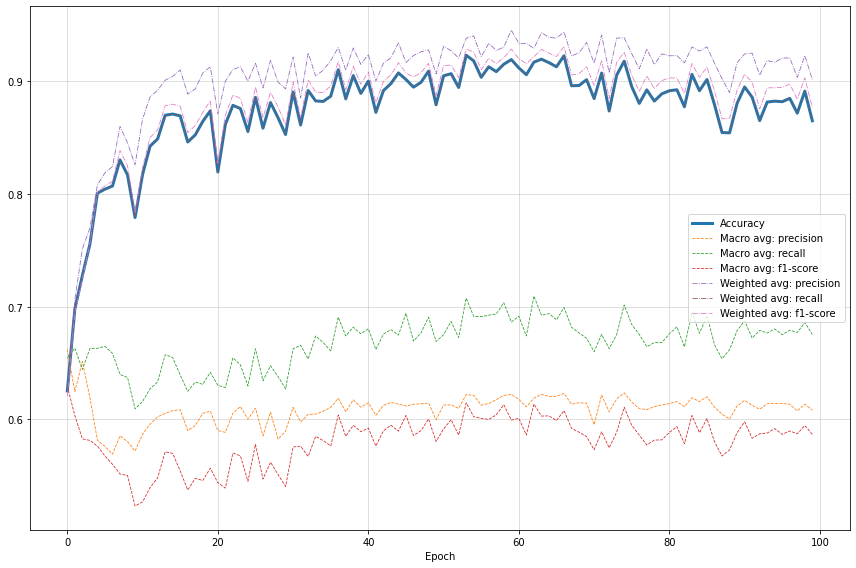

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))

ax1.set_xlabel("Epoch")

ax1.plot(classification_report_log_dict['accuracy'], label = 'Accuracy', linewidth = 3)

ax1.plot(classification_report_log_dict['macro avg']['precision'], 
         label = 'Macro avg: precision', linestyle='--', linewidth = 0.8)
ax1.plot(classification_report_log_dict['macro avg']['recall'], 
         label = 'Macro avg: recall', linestyle='--', linewidth = 0.8)
ax1.plot(classification_report_log_dict['macro avg']['f1-score'], 
         label = 'Macro avg: f1-score', linestyle='--', linewidth = 0.8)

ax1.plot(classification_report_log_dict['weighted avg']['precision'], 
         label = 'Weighted avg: precision', linestyle='-.', linewidth = 0.8)
ax1.plot(classification_report_log_dict['weighted avg']['recall'], 
         label = 'Weighted avg: recall', linestyle='-.', linewidth = 0.8)
ax1.plot(classification_report_log_dict['weighted avg']['f1-score'], 
         label = 'Weighted avg: f1-score', linestyle='-.', linewidth = 0.8)


ax1.legend(loc='best')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

Then precision for each class:

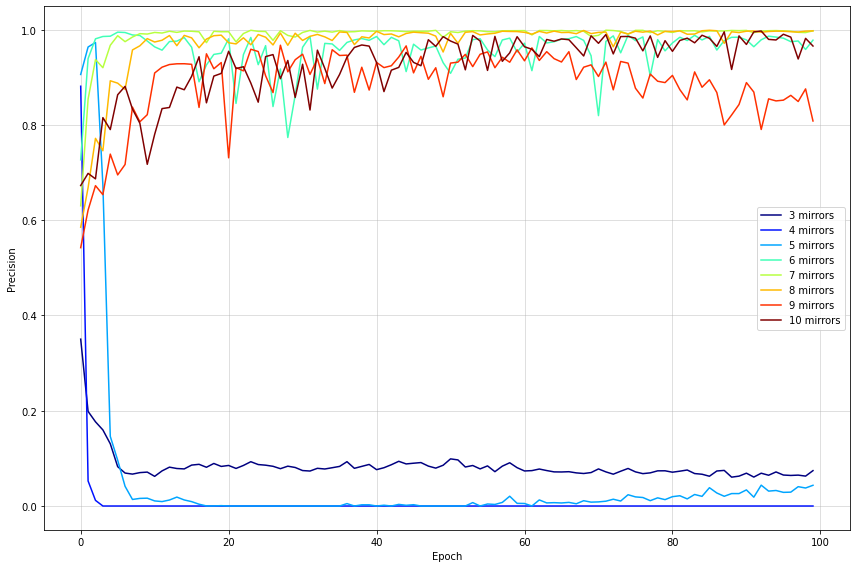

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))

metric = "Precision"
ax1.set_ylabel(metric)
ax1.set_xlabel("Epoch")

for class_id, col in zip(classes, colors):
    class_metric = metric + ": " + class_id + " mirrors"
    ax1.plot(classification_report_log_dict[class_id]['precision'], 
             label = class_id + ' mirrors', color=col)
    
ax1.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

Recall for each class:

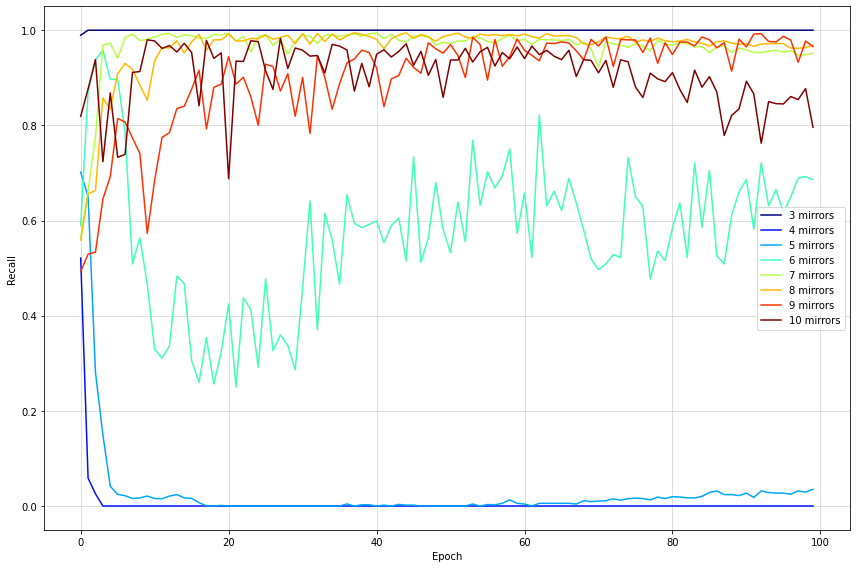

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))

metric = "Recall"
ax1.set_ylabel(metric)
ax1.set_xlabel("Epoch")

for class_id, col in zip(classes, colors):
    class_metric = metric + ": " + class_id + " mirrors"
    ax1.plot(classification_report_log_dict[class_id]['recall'], 
             label = class_id + ' mirrors', color=col)
    
ax1.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

And the F1 score for each class:

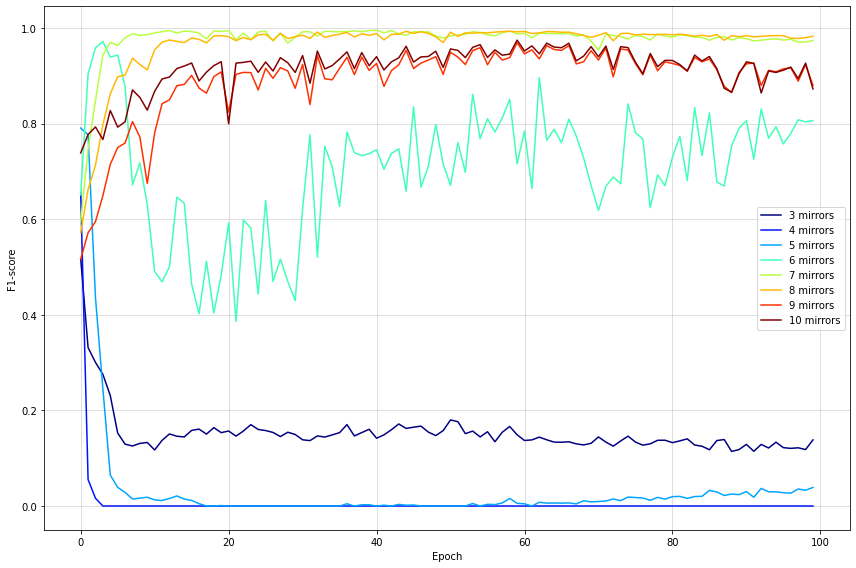

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))

metric = "F1-score"
ax1.set_ylabel(metric)
ax1.set_xlabel("Epoch")

for class_id, col in zip(classes, colors):
    class_metric = metric + ": " + class_id + " mirrors"
    ax1.plot(classification_report_log_dict[class_id]['f1-score'], 
             label = class_id + ' mirrors', color=col)
    
ax1.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

For completeness and convenience, we also output the final classification report in text form.

In [15]:
y_pred = model.predict(X_test, batch_size=len(X_test), verbose=1)
y_test_check = y_test
y_pred_check = np.argmax(y_pred, axis = 1)
print(classification_report(y_test_check, y_pred_check, target_names = classes))



1/1 [==============================] - 0s 55ms/step
              precision    recall  f1-score   support

           3       0.07      1.00      0.14       285
           4       0.00      0.00      0.00      1211
           5       0.04      0.04      0.04      3876
           6       0.98      0.69      0.81      9690
           7       1.00      0.95      0.97     19380
           8       1.00      0.97      0.98     31493
           9       0.81      0.97      0.88     41990
          10       0.97      0.80      0.87     46189

    accuracy                           0.87    154114
   macro avg       0.61      0.68      0.59    154114
weighted avg       0.90      0.87      0.88    154114



History for future reference:

In [16]:
print(classification_report_log_dict)


{'3': {'precision': [0.35031055900621116, 0.1986062717770035, 0.17679900744416874, 0.15975336322869954, 0.13067400275103164, 0.08263264714409974, 0.06919155134741442, 0.06699576868829338, 0.07011070110701106, 0.07119660254808893, 0.06228146853146853, 0.07373868046571798, 0.0815684029765312, 0.0787292817679558, 0.07789013391637059, 0.08592101296352125, 0.08753071253071253, 0.08133561643835617, 0.08931369476653087, 0.0831146106736658, 0.0851508813863161, 0.07888181566565182, 0.08517632994620443, 0.09301566579634465, 0.0870494807574832, 0.08571428571428572, 0.08338209479227618, 0.07836128677481441, 0.08362676056338028, 0.080896962815782, 0.07443196657090624, 0.0734346817830456, 0.07914468203276867, 0.07772020725388601, 0.08037225042301184, 0.08313885647607934, 0.0930764206401045, 0.07912270960577457, 0.08321167883211679, 0.0872627066748316, 0.07632565613283342, 0.08039492242595205, 0.08667883211678833, 0.09387351778656126, 0.08834469931804091, 0.08984867591424968, 0.0912, 0.08379888268156